<a href="https://colab.research.google.com/github/criscoutinho02/pneumonia_detection/blob/main/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/


In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:13<00:00, 246MB/s]
100% 2.29G/2.29G [00:13<00:00, 180MB/s]


In [4]:
import zipfile

zip_file_path='/content/chest-xray-pneumonia.zip'
extracted_dir_path='/content/chest-xray-pneumonia'


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [5]:
train_dir = '/content/chest-xray-pneumonia/chest_xray/train'
test_dir = '/content/chest-xray-pneumonia/chest_xray/test'

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size=32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)




Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 511ms/step - accuracy: 0.8249 - loss: 0.3646 - val_accuracy: 0.8830 - val_loss: 0.3059
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 481ms/step - accuracy: 0.9020 - loss: 0.2335 - val_accuracy: 0.8974 - val_loss: 0.2798
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 480ms/step - accuracy: 0.9368 - loss: 0.1757 - val_accuracy: 0.9071 - val_loss: 0.2658
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 466ms/step - accuracy: 0.9292 - loss: 0.1805 - val_accuracy: 0.9103 - val_loss: 0.2402
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 464ms/step - accuracy: 0.9382 - loss: 0.1616 - val_accuracy: 0.9103 - val_loss: 0.2485
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 475ms/step - accuracy: 0.9339 - loss: 0.1721 - val_accuracy: 0.9087 - val_loss: 0.2614
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 465ms/step - accuracy: 0.9388 - loss: 0.1558 - val_accuracy: 0.9103 - val_loss: 0.2343
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 464ms/step - accuracy: 0.9374 - loss: 

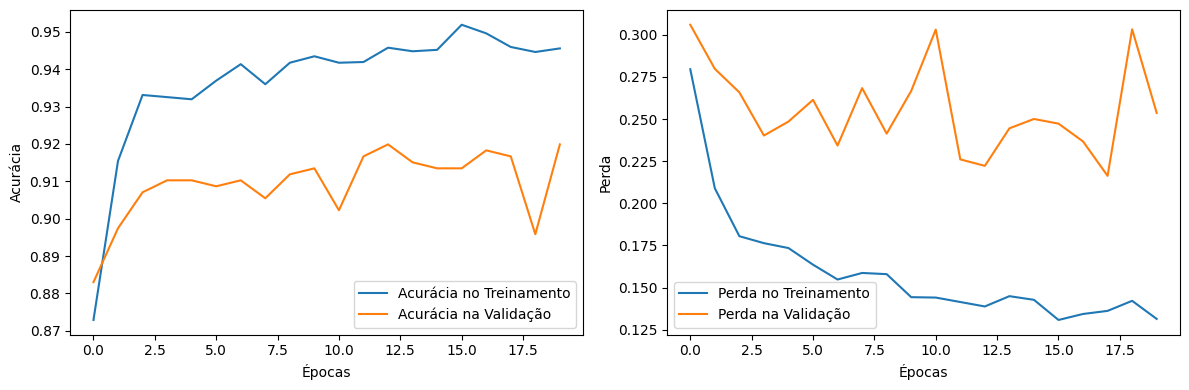

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

base_model.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

test_loss , test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Acurácia no conjunto de teste: {test_acc}')

test_labels = test_generator.classes
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("Matriz de Confusão:")
print(conf_matrix)

class_report = classification_report(test_labels, predicted_labels, target_names=['Normal', 'Pneumonia'])
print("Relatório de Classificação:")
print(class_report)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia no Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)


plt.plot(history.history['loss'], label='Perda no Treinamento')
plt.plot(history.history['val_loss'], label='Perda na Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()
